# DuckDB and file formats

This tutorial is slightly based on the DuckDB [tutorial](https://duckdb.org/2024/05/31/analyzing-railway-traffic-in-the-netherlands.html).

## Reading from files

The only thing needed to run DuckDB is importing it. To compare with Postgres, we will read the CSV file with train services in 2024.

By the way, it's highly recommended to always use multi-line strings in triple quotes for all queries, even the simplest ones. It makes them more readable, easier to modify, and removes escaping quotes.

In [1]:
import duckdb

duckdb.sql("""
SELECT *
FROM "data/services-2024.csv"
""")

┌────────────────┬──────────────┬──────────────┬─────────────────┬──────────────────────┬──────────────────────────────┬──────────────────────────┬───────────────────────┬─────────────┬───────────────────┬──────────────────────────┬──────────────────────────┬────────────────────┬────────────────────────┬──────────────────────────┬──────────────────────┬──────────────────────────┬──────────────────────┬───────────────────────┬──────────────────────┐
│ Service:RDT-ID │ Service:Date │ Service:Type │ Service:Company │ Service:Train number │ Service:Completely cancelled │ Service:Partly cancelled │ Service:Maximum delay │ Stop:RDT-ID │ Stop:Station code │    Stop:Station name     │    Stop:Arrival time     │ Stop:Arrival delay │ Stop:Arrival cancelled │   Stop:Departure time    │ Stop:Departure delay │ Stop:Departure cancelled │ Stop:Platform change │ Stop:Planned platform │ Stop:Actual platform │
│     int64      │     date     │   varchar    │     varchar     │        int64         │     

Now that was fast and easy! DuckDB parses CSV and infers type with [quite advanced features](https://duckdb.org/docs/stable/data/csv/auto_detection.html). You can also specify options manually ([documentation](https://duckdb.org/docs/stable/data/csv/overview.html)), e.g.:

`FROM read_csv("flights.csv", delim = "|")`.

Jupyter Notebook automatically prints the results, but we could also save them and call `.show()` explicitly. It is returned as `DuckDBPyRelation` object ([documentation](https://duckdb.org/docs/stable/clients/python/reference/#duckdb.DuckDBPyRelation)). You can use the object-oriented Relational API ([documentation](https://duckdb.org/docs/stable/clients/python/relational_api.html)) instead of writing SQL to compose queries based on Python language constructs. It's less popular than SQL though, and can be less readable.

In [2]:
results = duckdb.sql("""
SELECT *
FROM "data/services-2024.csv"
""")
print(type(results))
results.show()

<class '_duckdb.DuckDBPyRelation'>
┌────────────────┬──────────────┬──────────────┬─────────────────┬──────────────────────┬──────────────────────────────┬──────────────────────────┬───────────────────────┬─────────────┬───────────────────┬──────────────────────────┬──────────────────────────┬────────────────────┬────────────────────────┬──────────────────────────┬──────────────────────┬──────────────────────────┬──────────────────────┬───────────────────────┬──────────────────────┐
│ Service:RDT-ID │ Service:Date │ Service:Type │ Service:Company │ Service:Train number │ Service:Completely cancelled │ Service:Partly cancelled │ Service:Maximum delay │ Stop:RDT-ID │ Stop:Station code │    Stop:Station name     │    Stop:Arrival time     │ Stop:Arrival delay │ Stop:Arrival cancelled │   Stop:Departure time    │ Stop:Departure delay │ Stop:Departure cancelled │ Stop:Platform change │ Stop:Planned platform │ Stop:Actual platform │
│     int64      │     date     │   varchar    │     varcha

In [3]:
# last 10 rows
duckdb.sql("""
SELECT *
FROM "data/services-2024.csv"
ORDER BY "Service:Date"
LIMIT 10
""").show()

┌────────────────┬──────────────┬──────────────┬─────────────────┬──────────────────────┬──────────────────────────────┬──────────────────────────┬───────────────────────┬─────────────┬───────────────────┬─────────────────────────┬──────────────────────────┬────────────────────┬────────────────────────┬──────────────────────────┬──────────────────────┬──────────────────────────┬──────────────────────┬───────────────────────┬──────────────────────┐
│ Service:RDT-ID │ Service:Date │ Service:Type │ Service:Company │ Service:Train number │ Service:Completely cancelled │ Service:Partly cancelled │ Service:Maximum delay │ Stop:RDT-ID │ Stop:Station code │    Stop:Station name    │    Stop:Arrival time     │ Stop:Arrival delay │ Stop:Arrival cancelled │   Stop:Departure time    │ Stop:Departure delay │ Stop:Departure cancelled │ Stop:Platform change │ Stop:Planned platform │ Stop:Actual platform │
│     int64      │     date     │   varchar    │     varchar     │        int64         │       

In [4]:
# total number of late trains
duckdb.sql("""
SELECT COUNT(*)
FROM "data/services-2024.csv"
WHERE "Stop:Arrival delay" > 0
""")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      6153743 │
└──────────────┘

Queries like above are transient (in-memory). They can temporarily spill data to disk to process larger-than-memory datasets, but don't save results. In particular, each query needs to parse CSV file.

To make results persistent, we can create `.db` (or `.duckdb`) file, similarly to SQLite. This is useful for a few reasons:
- you want to save work and go home
- for storing intermediate computation results for longer workflows
- avoiding reading and parsing files, or downloading remote data

Such file holds regular tables, which can be created from other data sources.

In [5]:
db = duckdb.connect("data/duckdb_trains.db")
db

If you call methods on `db` object, they will be run on the database. If you use `duckdb` module, the default in-memory session will be used instead.

Let's create table from CSV and compare sizes with on-disk file.

In [6]:
import os

db.sql("""
CREATE TABLE IF NOT EXISTS services AS
FROM "data/services-2024.csv"
""")

csv_size_mb = os.path.getsize("data/services-2024.csv") // (1024 * 1024)
duckdb_size_mb = os.path.getsize("data/duckdb_trains.db") // (1024 * 1024)

print(f"CSV size: {csv_size_mb} MB")
print(f"DuckDB size: {duckdb_size_mb} MB")

CSV size: 3162 MB
DuckDB size: 450 MB


DuckDB uses many ["friendly SQL"](https://duckdb.org/docs/stable/sql/dialect/friendly_sql.html) extensions, which make SQL queries easier to write. They also offer many built-in features and functions. Some of them are DuckDB-exclusive, while others (e.g. PIVOT, UNPIVOT) are commonly adopted by many SQL databases.

Above, we use [FROM-first syntax](https://duckdb.org/docs/stable/sql/query_syntax/from.html#from-first-syntax), which allows omitting `SELECT *`. Without it, the query would be `AS SELECT * FROM ...`.

It also allows switching order of SELECT and FROM. Many people find this more readable. Let's see this in action.

In [7]:
db.sql("FROM services SELECT COUNT(*)")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│     21857914 │
└──────────────┘

Another friendly SQL extension is [DESCRIBE](https://duckdb.org/docs/stable/guides/meta/describe.html), which provides a summary of table columns, data types, and their basic features. It's very useful to verify the data after loading CSV or other unreliable formats. It even allows skipping SELECT and FROM altogether.

In [8]:
db.sql("DESCRIBE services")

┌──────────────────────────────┬──────────────────────────┬─────────┬─────────┬─────────┬─────────┐
│         column_name          │       column_type        │  null   │   key   │ default │  extra  │
│           varchar            │         varchar          │ varchar │ varchar │ varchar │ varchar │
├──────────────────────────────┼──────────────────────────┼─────────┼─────────┼─────────┼─────────┤
│ Service:RDT-ID               │ BIGINT                   │ YES     │ NULL    │ NULL    │ NULL    │
│ Service:Date                 │ DATE                     │ YES     │ NULL    │ NULL    │ NULL    │
│ Service:Type                 │ VARCHAR                  │ YES     │ NULL    │ NULL    │ NULL    │
│ Service:Company              │ VARCHAR                  │ YES     │ NULL    │ NULL    │ NULL    │
│ Service:Train number         │ BIGINT                   │ YES     │ NULL    │ NULL    │ NULL    │
│ Service:Completely cancelled │ BOOLEAN                  │ YES     │ NULL    │ NULL    │ NULL    │


Let's see a few examples of queries on this table:

In [9]:
# number of all the services
db.sql("""
SELECT COUNT(DISTINCT "Service:RDT-ID") 
FROM services
""")

┌──────────────────────────────────┐
│ count(DISTINCT "Service:RDT-ID") │
│              int64               │
├──────────────────────────────────┤
│                          2395636 │
└──────────────────────────────────┘

In [10]:
# number of stops per service
db.sql("""
SELECT "Service:RDT-ID",
       COUNT(*) AS num_stops
FROM services
GROUP BY "Service:RDT-ID"
ORDER BY num_stops DESC
"""
)

┌────────────────┬───────────┐
│ Service:RDT-ID │ num_stops │
│     int64      │   int64   │
├────────────────┼───────────┤
│       13136166 │        40 │
│       13135724 │        40 │
│       13135118 │        40 │
│       13134703 │        40 │
│       13137078 │        40 │
│       13135311 │        40 │
│       13137270 │        40 │
│       13134909 │        40 │
│       13136903 │        40 │
│       13135987 │        40 │
│           ·    │         · │
│           ·    │         · │
│           ·    │         · │
│       12960500 │        23 │
│       14582426 │        23 │
│       14868946 │        23 │
│       12972061 │        23 │
│       13407444 │        23 │
│       14073174 │        23 │
│       14635327 │        23 │
│       13564467 │        23 │
│       13470680 │        23 │
│       12921153 │        23 │
├────────────────┴───────────┤
│ ? rows           2 columns │
│ (>9999 rows, 20 shown)     │
└────────────────────────────┘

In [11]:
# average arrival delay per service type
db.sql("""
SELECT "Service:Type",
       AVG("Stop:Arrival delay") AS avg_arrival_delay
FROM services
WHERE "Stop:Arrival delay" IS NOT NULL
GROUP BY "Service:Type"
ORDER BY avg_arrival_delay DESC
""")

┌───────────────────┬───────────────────────┐
│   Service:Type    │   avg_arrival_delay   │
│      varchar      │        double         │
├───────────────────┼───────────────────────┤
│ European Sleeper  │    13.104823151125402 │
│ Stoomtrein        │                  12.0 │
│ Nightjet          │     9.099788781976063 │
│ Eurostar          │     7.788637531155463 │
│ ICE International │     6.904159898297903 │
│ Int. Trein        │     4.480769230769231 │
│ Nachttrein        │     3.885049365303244 │
│ Intercity direct  │     3.252410781587087 │
│ Extra trein       │    2.9482057627717873 │
│ Eurocity Direct   │    2.2482360487491984 │
│ Sneltrein         │    1.7591278687918004 │
│ EuroCity          │    1.4974285126517177 │
│ Intercity         │    1.2479878711782384 │
│ Speciale Trein    │    0.9782588323493581 │
│ Sprinter          │    0.8619189684480987 │
│ Stoptrein         │    0.7848326562950719 │
│ Stopbus ipv trein │ 0.0005534048555484629 │
│ Snelbus ipv trein │ 4.9159374692

**Exercises**

1. Which 10 stations were busiest, i.e. got the most train arrivals or departures?
2. Load file `data/disruptions-2023.csv` as `disruptions` table. Describe it.
3. What were the 5 most frequent disruption causes in 2023, and how many times did they occur?
4. Select the row with the longest disruption. What was the cause? How long was it in days?

In [12]:
# 1
db.sql("""
SELECT "Stop:Station name",
       COUNT(*) AS num_stops
FROM services
WHERE "Stop:Arrival cancelled" = 'false' AND "Stop:Departure cancelled" = 'false'
GROUP BY "Stop:Station name"
ORDER BY num_stops DESC
LIMIT 10
""")

┌──────────────────────┬───────────┐
│  Stop:Station name   │ num_stops │
│       varchar        │   int64   │
├──────────────────────┼───────────┤
│ Amsterdam Sloterdijk │    260351 │
│ Utrecht Centraal     │    236068 │
│ Schiphol Airport     │    201997 │
│ Gouda                │    153991 │
│ Leiden Centraal      │    142831 │
│ Amsterdam Zuid       │    133976 │
│ Rotterdam Centraal   │    133381 │
│ Amsterdam Centraal   │    119230 │
│ Amersfoort Centraal  │    116260 │
│ Delft                │    114833 │
├──────────────────────┴───────────┤
│ 10 rows                2 columns │
└──────────────────────────────────┘

In [13]:
# 2
db.sql("""
CREATE TABLE IF NOT EXISTS disruptions AS
FROM "data/disruptions-2023.csv"
""")

db.sql("DESCRIBE disruptions")


┌──────────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│     column_name      │ column_type │  null   │   key   │ default │  extra  │
│       varchar        │   varchar   │ varchar │ varchar │ varchar │ varchar │
├──────────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ rdt_id               │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ ns_lines             │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ rdt_lines            │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ rdt_lines_id         │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ rdt_station_names    │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ rdt_station_codes    │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ cause_nl             │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ cause_en             │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ statistical_cause_nl │ VARCHAR     │ YES     │ NUL

In [14]:
# 3
db.sql("""
SELECT "cause_nl",
       "cause_en",
       COUNT(*) AS number_of_occurrences
FROM disruptions
GROUP BY "cause_nl", "cause_en"
ORDER BY number_of_occurrences DESC
LIMIT 5
""")

┌────────────────────────┬───────────────────────────────┬───────────────────────┐
│        cause_nl        │           cause_en            │ number_of_occurrences │
│        varchar         │            varchar            │         int64         │
├────────────────────────┼───────────────────────────────┼───────────────────────┤
│ defecte trein          │ broken down train             │                  1702 │
│ aanrijding             │ collision                     │                   493 │
│ sein- en wisselstoring │ signalling and points failure │                   288 │
│ wisselstoring          │ points failure                │                   230 │
│ seinstoring            │ signal failure                │                   161 │
└────────────────────────┴───────────────────────────────┴───────────────────────┘

In [15]:
# 4 I will not select full row, because of nice and readable output
print("I will not select full row, because of nice and readable output")
db.sql("""
SELECT rdt_id,
       cause_en,
       duration_minutes,
       duration_minutes / 1440.0 as duration_in_days
FROM disruptions
ORDER BY duration_minutes DESC
LIMIT 1
""")


I will not select full row, because of nice and readable output


┌────────┬──────────────┬──────────────────┬────────────────────┐
│ rdt_id │   cause_en   │ duration_minutes │  duration_in_days  │
│ int64  │   varchar    │      int64       │       double       │
├────────┼──────────────┼──────────────────┼────────────────────┤
│  46998 │ repair works │            41339 │ 28.707638888888887 │
└────────┴──────────────┴──────────────────┴────────────────────┘

## Connecting to databases

DuckDB can connect to various data sources, e.g. Excel, databases, cloud files, data lakehouses, and others. It uses a system of [extensions](https://duckdb.org/docs/stable/extensions/overview), which are loaded explicitly. This avoids bloating the base package and is very flexible. We will now install and load the Postgres extension, and query the database.

Make sure that PostgreSQL is up and running in Docker Compose.

In [16]:
# install and import extension
db.sql("""INSTALL postgres; LOAD postgres;""")

# NEVER write password like this explicitly in real code!
conn_string = "host=localhost user=postgres password=postgres dbname=postgres"

# note that we create the alias for this Postgres database here
# this also needs to be in single quotes
db.sql(f"""
ATTACH IF NOT EXISTS '{conn_string}' AS postgres_db_read (TYPE postgres, READ_ONLY);
""")

In [17]:
# command to list all tables available
db.sql("SHOW ALL TABLES")

┌──────────────────┬─────────┬─────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬───────────┐
│     database     │ schema  │    name     │                                                                                                                                                                                                                             column_names   

You can securely store connections information in [DuckDB secrets](https://duckdb.org/docs/stable/extensions/postgres.html#configuring-via-secrets). Here, we make a read-only connection, but DuckDB can also [write to Postgres](https://duckdb.org/docs/stable/extensions/postgres.html#writing-data-to-postgresql). This way you can e.g. insert Parquet data into Postgres, which is not supported natively.

When a database is attached, the data is queried from it each time. It guarantees the newest data, but also results in networking overhead. You can [copy Postgres table](https://duckdb.org/docs/stable/extensions/postgres.html#usage) into DuckDB to avoid this, but you have stale data this way.

We have two `services` tables now - to query the Postgres one, we prefix it with database alias. Compare querying Postgres and DuckDB tables.

In [18]:
db.sql("""
SELECT COUNT(*)
FROM postgres_db_read.services
""")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│     21857914 │
└──────────────┘

In [19]:
db.sql("""
SELECT COUNT(*)
FROM services
""")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│     21857914 │
└──────────────┘

You can run any queries this way, e.g. JOIN files and databases, insert and update data sources, and more. To remove a database, use DETACH command:

In [20]:
db.sql("DETACH postgres_db_read")

**Exercise**

1. Download data about disruptions from 2022 ([Rijden de Treinen page](https://www.rijdendetreinen.nl/en/open-data/disruptions)). You can use either Python (e.g. [urllib](https://stackoverflow.com/a/19602990/9472066)) or wget.
2. Create read-write connection to Postgres.
3. Use [Postgres CREATE TABLE](https://duckdb.org/docs/stable/extensions/postgres.html#create-table) in DuckDB to insert both 2023 and 2024 disruptions data into Postgres database as `disruptions` table. See [documentation about reading multiple files](https://duckdb.org/docs/stable/data/multiple_files/overview.html).
4. Query how many disruptions occurred in 2022 and 2023.

In [21]:
# 2
db.sql(f"""
ATTACH IF NOT EXISTS '{conn_string}' AS postgres_db (TYPE postgres);
""")

In [22]:
# 3
db.sql(f"DESCRIBE 'data/disruptions-2023.csv'").df() == db.sql(f"DESCRIBE 'data/disruptions-2022.csv'").df()
# We only care about column_name and column_type

,column_name,column_type,null,key,default,extra
0,True,True,True,False,False,False
1,True,True,True,False,False,False
2,True,True,True,False,False,False
3,True,True,True,False,False,False
4,True,True,True,False,False,False
5,True,True,True,False,False,False
6,True,True,True,False,False,False
7,True,True,True,False,False,False
8,True,True,True,False,False,False
9,True,True,True,False,False,False


In [23]:
schema_df = db.sql(f"DESCRIBE 'data/disruptions-2023.csv'").df()
schema_df

,column_name,column_type,null,key,default,extra
0,rdt_id,BIGINT,YES,None,None,None
1,ns_lines,VARCHAR,YES,None,None,None
2,rdt_lines,VARCHAR,YES,None,None,None
3,rdt_lines_id,VARCHAR,YES,None,None,None
4,rdt_station_names,VARCHAR,YES,None,None,None
5,rdt_station_codes,VARCHAR,YES,None,None,None
6,cause_nl,VARCHAR,YES,None,None,None
7,cause_en,VARCHAR,YES,None,None,None
8,statistical_cause_nl,VARCHAR,YES,None,None,None
9,statistical_cause_en,VARCHAR,YES,None,None,None


In [24]:
column_defs = []
for index, row in schema_df.iterrows():
    col_name = row['column_name']
    col_type = row['column_type']

    column_defs.append(f'"{col_name}" {col_type}')

column_sql = ",\n    ".join(column_defs)

In [28]:
create_table_sql = f"""
CREATE TABLE IF NOT EXISTS postgres_db.disruptions (
    {column_sql}
);
"""

In [29]:
print(create_table_sql)


CREATE TABLE IF NOT EXISTS postgres_db.disruptions (
    "rdt_id" BIGINT,
    "ns_lines" VARCHAR,
    "rdt_lines" VARCHAR,
    "rdt_lines_id" VARCHAR,
    "rdt_station_names" VARCHAR,
    "rdt_station_codes" VARCHAR,
    "cause_nl" VARCHAR,
    "cause_en" VARCHAR,
    "statistical_cause_nl" VARCHAR,
    "statistical_cause_en" VARCHAR,
    "cause_group" VARCHAR,
    "start_time" TIMESTAMP,
    "end_time" TIMESTAMP,
    "duration_minutes" BIGINT
);



In [30]:
db.sql(create_table_sql)

In [42]:
db.sql("""
INSERT INTO postgres_db.disruptions
SELECT * FROM 'data/disruptions-2022.csv'
UNION ALL
SELECT * FROM 'data/disruptions-2022.csv';
""")

In [43]:
db.sql("""
SELECT * FROM postgres_db.disruptions LIMIT 3
""").df()

,rdt_id,ns_lines,rdt_lines,rdt_lines_id,rdt_station_names,rdt_station_codes,cause_nl,cause_en,statistical_cause_nl,statistical_cause_en,cause_group,start_time,end_time,duration_minutes
0,40500,Den Haag-Rotterdam; Leiden-Rotterdam,Den Haag HS - Rotterdam Centraal,11,"Delft,Delft Campus,Den Haag HS,Den Haag Moerwi...","DT, DTCP, GV, GVMW, RSW",brandmelding,fire alarm,brandmelding,fire alarm,external,2022-01-01 05:45:33,2022-01-01 06:34:58,49
1,40501,Amsterdam-Utrecht; Utrecht-Eindhoven,"'s-Hertogenbosch - Utrecht Centraal, Amsterdam...","136,151","Abcoude,Amsterdam Amstel,Amsterdam Bijlmer Are...","AC, ASA, ASB, ASD, ASDM, ASHD, BKL, CL, DVD, G...",herstelwerkzaamheden,repair works,herstelwerkzaamheden,repair works,engineering work,2022-01-01 06:23:54,2022-01-01 13:59:14,455
2,40502,Schiphol-Rotterdam (HSL),Rotterdam Centraal - Schiphol Airport (HSL),24,"Rotterdam Centraal,Schiphol Airport","RTD, SHL",brandmelding,fire alarm,brandmelding,fire alarm,external,2022-01-01 06:33:40,2022-01-01 06:34:27,1


In [31]:
# 4
db.sql("""
SELECT COUNT(*) as number_of_disruptions
FROM postgres_db.disruptions
""")

┌───────────────────────┐
│ number_of_disruptions │
│         int64         │
├───────────────────────┤
│                 10998 │
└───────────────────────┘

## Writing data

DuckDB can not only insert data into databases, but also write regular files to disk, for example [JSON and JSON Lines](https://duckdb.org/docs/stable/data/json/writing_json) and [Parquet](https://duckdb.org/docs/stable/data/parquet/overview). It also makes it very convenient as a format conversion tool, e.g. as a first part in a data processing workflow.

DuckDB is very fast at reading CSV, and [gets faster over time](https://duckdb.org/2024/06/26/benchmarks-over-time.html#csv-reader). However, its unique feature is [very robust and advanced CSV parsing](https://duckdb.org/2023/10/27/csv-sniffer.html), based on paper ["Multiple hypothesis CSV parsing" T. Döhmen et al.](https://hannes.muehleisen.org/publications/ssdbm2017-muehleisen-csvs.pdf), and in case of errors it has [verbose error informations](https://duckdb.org/docs/stable/data/csv/reading_faulty_csv_files), as well as option to omit faulty lines.

Let's read the CSV file with 2024 train services and change it to TSV (tab-separated values) file. Exporting files also uses COPY command, with format-specific options ([documentation](https://duckdb.org/docs/stable/sql/statements/copy.html#csv-options)).

In [32]:
duckdb.sql("""
COPY (SELECT * FROM "data/services-2024.csv") TO "data/services_2024_duckdb.tsv" (HEADER, DELIMITER "\t");
""")

with open("data/services_2024_duckdb.tsv") as file:
    i = 0
    for i, line in enumerate(file):
        i += 1
        print(line)
        if i == 5:
            break

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Service:RDT-ID	Service:Date	Service:Type	Service:Company	Service:Train number	Service:Completely cancelled	Service:Partly cancelled	Service:Maximum delay	Stop:RDT-ID	Stop:Station code	Stop:Station name	Stop:Arrival time	Stop:Arrival delay	Stop:Arrival cancelled	Stop:Departure time	Stop:Departure delay	Stop:Departure cancelled	Stop:Platform change	Stop:Planned platform	Stop:Actual platform

12690865	2024-01-01	Intercity	NS	1410	false	false	2	114307592	RTD	Rotterdam Centraal				2024-01-01 02:00:00+01	0	false	false	9	9

12690865	2024-01-01	Intercity	NS	1410	false	false	0	114307593	DT	Delft	2024-01-01 02:13:00+01	0	false	2024-01-01 02:13:00+01	0	false	false	1	1

12690865	2024-01-01	Intercity	NS	1410	false	false	0	114307594	GV	Den Haag HS	2024-01-01 02:21:00+01	0	false	2024-01-01 02:22:00+01	0	false	false	6	6

12690865	2024-01-01	Intercity	NS	1410	false	false	0	114307595	LEDN	Leiden Centraal	2024-01-01 02:35:00+01	0	false	2024-01-01 02:40:00+01	0	false	true	5b	8b



**Exercise**

1. Convert the 2024 services file into JSON, JSON Lines and Parquet files. Use ZSTD compression for Parquet. Use [DuckDB documentation](https://duckdb.org/docs/stable/sql/statements/copy.html#format-specific-options).
2. Compare file size of each file format (including CSV) in MB.
3. Compare loading time of each file format (including CSV), e.g. to count how many trains arrived at Rotterdam Centraal station. Use `time` module. Report mean time of 3 repetitions.

In [40]:
# 1
db.sql("COPY (FROM 'data/services-2024.csv') TO 'data/services-2024.json' (FORMAT JSON, ARRAY TRUE);")
db.sql("COPY (FROM 'data/services-2024.csv') TO 'data/services-2024.jsonl' (FORMAT JSON, ARRAY FALSE);")
db.sql("COPY (FROM 'data/services-2024.csv') TO 'data/services-2024.parquet' (FORMAT PARQUET, CODEC ZSTD);")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [41]:
# 2
import glob

search_pattern = os.path.join("data", "services-2024.*")
file_paths = glob.glob(search_pattern)

for file_path in file_paths:
    if os.path.isfile(file_path):

        file_extension = file_path.split(".")[-1]

        size_bytes = os.path.getsize(file_path)

        print(f"{file_extension} Size: {size_bytes / (1024 ** 2):.2f} MB ({size_bytes} bytes)")

csv Size: 3162.43 MB (3316053270 bytes)
jsonl Size: 12530.22 MB (13138889427 bytes)
parquet Size: 178.75 MB (187437498 bytes)
json Size: 12571.91 MB (13182605258 bytes)


In [71]:
# 3
import time

def benchmark_duckdb_query(query, runs=3):
    times = []

    for i in range(runs):
        start_time = time.perf_counter()

        db.sql(query)

        end_time = time.perf_counter()

        elapsed_time = end_time - start_time
        times.append(elapsed_time)

    mean_time = sum(times) / len(times)

    return mean_time

In [72]:
query_template = """
SELECT COUNT(*) as trains_arrived
FROM '{}'
WHERE "Stop:Station name" = 'Rotterdam Centraal'
"""

In [77]:
file_tab = [
    'data/services-2024.csv',
    'data/services-2024.json',
    'data/services-2024.jsonl',
    'data/services-2024.parquet'
]

for file_path in file_tab:
    file_extension = file_path.split(".")[-1]

    query = query_template.format(file_path)
    t = benchmark_duckdb_query(query)
    print(f"Avg time for {file_extension} is {t * 1000 :.4f} micro seconds")

Avg time for csv is 66.4451 micro seconds
Avg time for json is 88.9684 micro seconds
Avg time for jsonl is 52.5388 micro seconds
Avg time for parquet is 2.1188 micro seconds


## DuckDB interoperability

DuckDB is highly interoperable with Python and with data processing frameworks like Pandas and Polars. It can convert results to them, as well as query DataFrames with SQL. This has a few uses:
- switch to SQL whenever you want
- use DuckDB for fast and robust data reading, e.g. for CSV
- convert to Pandas for plotting the results
- pool data from various sources with DuckDB and then build complex workflows with DataFrames

Getting results in Python works similarly to `psycopg`, with methods `.fetchone()` and `.fetchall()`.

Let's see how many services were run in January and December 2024.

In [79]:
num_jan_services = db.sql("""
SELECT COUNT(DISTINCT "Service:RDT-ID")
FROM "data/services-2024.csv"
WHERE "Service:Date" BETWEEN '2024-01-01' AND '2024-01-31'
""")
num_jan_services = num_jan_services.fetchone()[0]

num_dec_services = db.sql("""
SELECT COUNT(DISTINCT "Service:RDT-ID")
FROM "data/services-2024.csv"
WHERE "Service:Date" BETWEEN '2024-12-01' AND '2024-12-31'
""")
num_dec_services = num_dec_services.fetchone()[0]

print(f"January services: {num_jan_services}")
print(f"December services: {num_dec_services}")

January services: 187778
December services: 186992


Converting to Pandas is similar, with method `.to_df()` (aliases: `.fetch_df()`, `.df()`). Let's fetch all services by month.

In [80]:
num_monthly_services = db.sql("""
SELECT MONTH("Service:Date") AS month, COUNT(DISTINCT "Service:RDT-ID") AS num_services 
FROM "data/services-2024.csv"
GROUP BY MONTH("Service:Date")
ORDER BY month
""").df()

num_monthly_services

,month,num_services
0,1,187778
1,2,193117
2,3,202644
3,4,190436
4,5,203625
5,6,200795
6,7,227031
7,8,202115
8,9,186368
9,10,219174


Since we're already here, let's visualize this with Matplotlib. Pandas has handy shortcuts in `.plot` method ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)).

<Axes: title={'center': 'Number of services in 2024 by month'}, xlabel='month'>

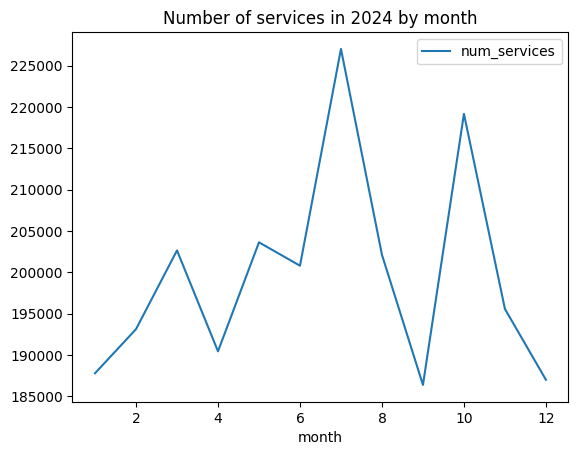

In [35]:
num_monthly_services.plot.line(
    x="month", y="num_services", title="Number of services in 2024 by month"
)

We can also query Pandas DataFrames by just using variable names like tables. Note that we should use Arrow backend for good performance here. Let's load the disruptions from 2023 and check for frequency of top 10 most popular causes. Then we will go back to Pandas and make a bar plot.

<Axes: ylabel='cause'>

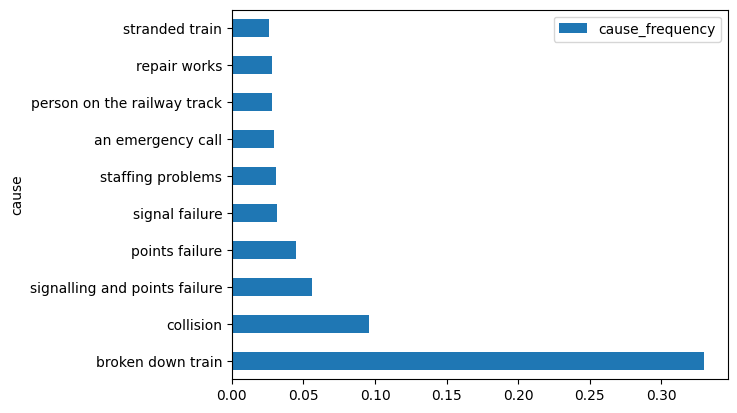

In [36]:
import pandas as pd

df_disruptions = pd.read_csv("data/disruptions-2023.csv", dtype_backend="pyarrow")

df_disruptions_statistics = duckdb.sql("""
SELECT statistical_cause_en AS cause, COUNT(*) / (SELECT COUNT(*) FROM df_disruptions) AS cause_frequency
FROM df_disruptions
GROUP BY statistical_cause_en
ORDER BY cause_frequency DESC
LIMIT 10
""").df()

df_disruptions_statistics.plot.barh(x="cause", y="cause_frequency")

**Exercise**

1. Extract the average daily arrival delays of 2024 train services with DuckDB. Note that NULL delay means zero, and you have to use [COALESCE function](https://duckdb.org/docs/stable/sql/functions/utility.html#coalesceexpr-) to fill them as zeros.
2. Visualize those changes over time with Pandas on a line plot. Plot daily average, and also rolling mean (average) of 7 and 30 days to analyze longer trends.

In [93]:
# 1
db.sql("""
SELECT AVG(COALESCE("Stop:Arrival delay", 0)) AS avg_daily_delay
FROM "data/services-2024.parquet"
WHERE "Service:Date" BETWEEN '2024-01-01' AND '2024-12-31'
""")

┌────────────────────┐
│  avg_daily_delay   │
│       double       │
├────────────────────┤
│ 0.8926532513578377 │
└────────────────────┘

In [112]:

db.sql("""
    SELECT AVG(COALESCE("Stop:Arrival delay", 0)) AS avg_daily_delay
    FROM "data/services-2024.parquet"
    WHERE "Service:Date" BETWEEN '2024-01-01' AND '2024-12-31'
    GROUP BY "Service:Date"
""")

┌─────────────────────┐
│   avg_daily_delay   │
│       double        │
├─────────────────────┤
│  0.5596716786518486 │
│  0.8803124946811227 │
│  0.9102213928238189 │
│  0.7770827743493426 │
│  0.6963462464735429 │
│  0.6792366745353197 │
│  0.7617416507476451 │
│  0.9680910444058546 │
│  1.0975883426588073 │
│  1.1612464642360405 │
│           ·         │
│           ·         │
│           ·         │
│  0.6657164537232625 │
│  0.5404017038112406 │
│  0.5271994627266622 │
│  0.4381091516226651 │
│  0.5335875623349956 │
│  0.6407907043101945 │
│  0.5728982626619552 │
│  0.5418663776934939 │
│  0.5877462956499667 │
│ 0.44689952829287855 │
├─────────────────────┤
│ 366 rows (20 shown) │
└─────────────────────┘

In [114]:
df = db.sql("""
WITH DailyAggregates AS (
    SELECT
        "Service:Date",
        AVG(COALESCE("Stop:Arrival delay", 0)) AS avg_daily_delay
    FROM "data/services-2024.parquet"
    WHERE "Service:Date" BETWEEN '2024-01-01' AND '2024-12-31'
    GROUP BY "Service:Date"
)
SELECT
    "Service:Date",
    avg_daily_delay,
    AVG(avg_daily_delay) OVER (
        ORDER BY "Service:Date" ASC
        ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
    ) AS seven_day_rolling_delay,
    AVG(avg_daily_delay) OVER (
        ORDER BY "Service:Date" ASC
        ROWS BETWEEN 29 PRECEDING AND CURRENT ROW
    ) AS twenty_nine_day_rolling_delay
FROM
    DailyAggregates
ORDER BY
    "Service:Date"
""").df()

df

,Service:Date,avg_daily_delay,seven_day_rolling_delay,twenty_nine_day_rolling_delay
0,2024-01-01,0.559672,0.559672,0.559672
1,2024-01-02,0.880312,0.719992,0.719992
2,2024-01-03,0.910221,0.783402,0.783402
3,2024-01-04,0.777083,0.781822,0.781822
4,2024-01-05,0.696346,0.764727,0.764727
...,...,...,...,...
361,2024-12-27,0.640791,0.589631,0.910382
362,2024-12-28,0.572898,0.559815,0.877019
363,2024-12-29,0.541866,0.542122,0.844232
364,2024-12-30,0.587746,0.548885,0.831327


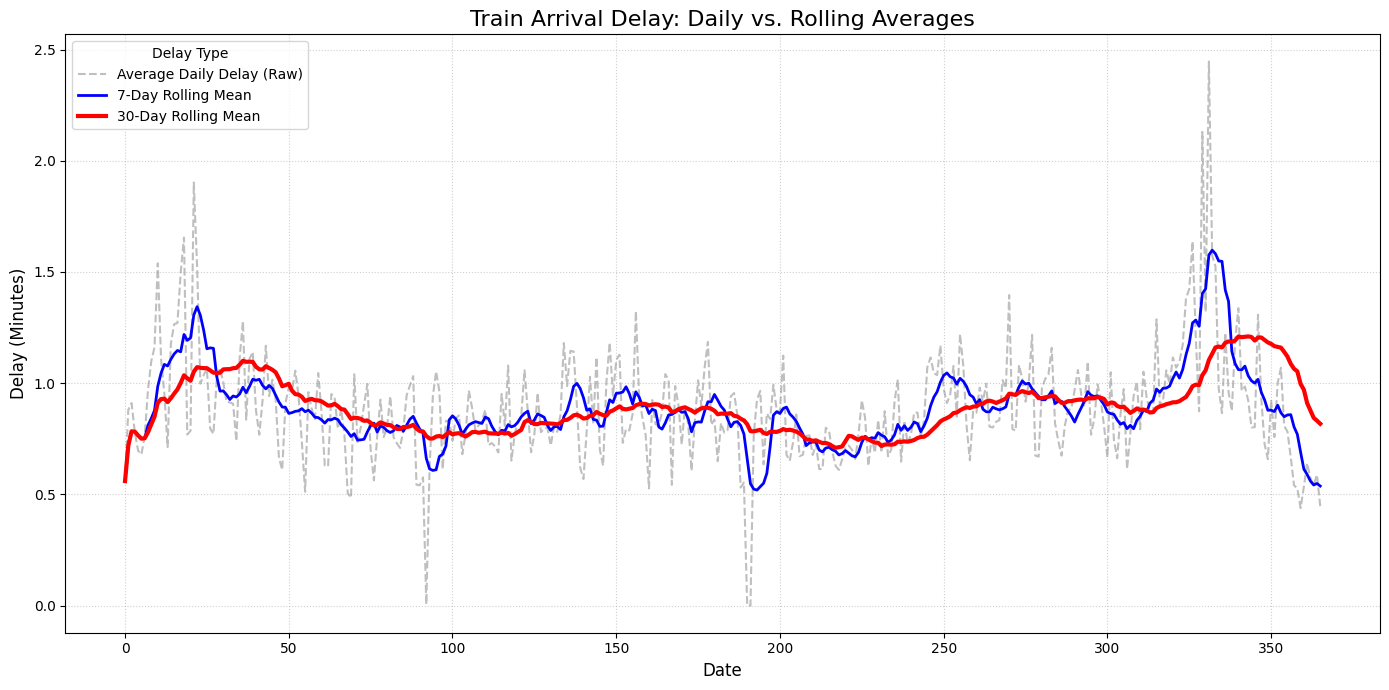

In [116]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

df['avg_daily_delay'].plot(
    label='Average Daily Delay (Raw)',
    linestyle='--',
    alpha=0.5,
    color='gray'
)

df['seven_day_rolling_delay'].plot(
    label='7-Day Rolling Mean',
    linewidth=2,
    color='blue'
)

df['twenty_nine_day_rolling_delay'].plot(
    label='30-Day Rolling Mean',
    linewidth=3,
    color='red'
)

plt.title('Train Arrival Delay: Daily vs. Rolling Averages', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Delay (Minutes)', fontsize=12)
plt.legend(title='Delay Type')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()